In [1]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import torch
torch.cuda.device_count()

C:\Users\bater\anaconda3\envs\lseg37\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1

In [1]:
import os
import argparse
import numpy as np
from tqdm import tqdm
from collections import OrderedDict

import torch
import torch.nn.functional as F
from torch.utils import data
import torchvision.transforms as transform
from torch.nn.parallel.scatter_gather import gather

import encoding.utils as utils
from encoding.nn import SegmentationLosses, SyncBatchNorm
from encoding.parallel import DataParallelModel, DataParallelCriterion
from encoding.datasets import test_batchify_fn 
from encoding.models.sseg import BaseNet
from additional_utils.models import LSeg_MultiEvalModule
from modules.lseg_module import LSegModule

import math
import types
import functools
import torchvision.transforms as torch_transforms
import copy
import itertools
from PIL import Image
import matplotlib.pyplot as plt
import clip
import matplotlib as mpl
import matplotlib.colors as mplc
import matplotlib.figure as mplfigure
import matplotlib.patches as mpatches
from matplotlib.backends.backend_agg import FigureCanvasAgg
from data import get_dataset
import torchvision.transforms as transforms

class Options:
    def __init__(self):
        parser = argparse.ArgumentParser(description="PyTorch Segmentation")
        # model and dataset
        parser.add_argument(
            "--model", type=str, default="encnet", help="model name (default: encnet)"
        )
        parser.add_argument(
            "--backbone",
            type=str,
            default="clip_vitl16_384",
            help="backbone name (default: resnet50)",
        )
        parser.add_argument(
            "--dataset",
            type=str,
            default="ade20k",
            help="dataset name (default: pascal12)",
        )
        parser.add_argument(
            "--workers", type=int, default=16, metavar="N", help="dataloader threads"
        )
        parser.add_argument(
            "--base-size", type=int, default=520, help="base image size"
        )
        parser.add_argument(
            "--crop-size", type=int, default=480, help="crop image size"
        )
        parser.add_argument(
            "--train-split",
            type=str,
            default="train",
            help="dataset train split (default: train)",
        )
        parser.add_argument(
            "--aux", action="store_true", default=False, help="Auxilary Loss"
        )
        parser.add_argument(
            "--se-loss",
            action="store_true",
            default=False,
            help="Semantic Encoding Loss SE-loss",
        )
        parser.add_argument(
            "--se-weight", type=float, default=0.2, help="SE-loss weight (default: 0.2)"
        )
        parser.add_argument(
            "--batch-size",
            type=int,
            default=16,
            metavar="N",
            help="input batch size for \
                            training (default: auto)",
        )
        parser.add_argument(
            "--test-batch-size",
            type=int,
            default=16,
            metavar="N",
            help="input batch size for \
                            testing (default: same as batch size)",
        )
        # cuda, seed and logging
        parser.add_argument(
            "--no-cuda",
            action="store_true",
            default=False,
            help="disables CUDA training",
        )
        parser.add_argument(
            "--seed", type=int, default=1, metavar="S", help="random seed (default: 1)"
        )
        # checking point
        parser.add_argument(
            "--weights", type=str, default='', help="checkpoint to test"
        )
        # evaluation option
        parser.add_argument(
            "--eval", action="store_true", default=False, help="evaluating mIoU"
        )
        parser.add_argument(
            "--export",
            type=str,
            default=None,
            help="put the path to resuming file if needed",
        )
        parser.add_argument(
            "--acc-bn",
            action="store_true",
            default=False,
            help="Re-accumulate BN statistics",
        )
        parser.add_argument(
            "--test-val",
            action="store_true",
            default=False,
            help="generate masks on val set",
        )
        parser.add_argument(
            "--no-val",
            action="store_true",
            default=False,
            help="skip validation during training",
        )

        parser.add_argument(
            "--module",
            default='lseg',
            help="select model definition",
        )

        # test option
        parser.add_argument(
            "--data-path", type=str, default='../datasets/', help="path to test image folder"
        )

        parser.add_argument(
            "--no-scaleinv",
            dest="scale_inv",
            default=True,
            action="store_false",
            help="turn off scaleinv layers",
        )

        parser.add_argument(
            "--widehead", default=False, action="store_true", help="wider output head"
        )

        parser.add_argument(
            "--widehead_hr",
            default=False,
            action="store_true",
            help="wider output head",
        )
        parser.add_argument(
            "--ignore_index",
            type=int,
            default=-1,
            help="numeric value of ignore label in gt",
        )
        
        parser.add_argument(
            "--label_src",
            type=str,
            default="default",
            help="how to get the labels",
        )
        
        parser.add_argument(
            "--arch_option",
            type=int,
            default=0,
            help="which kind of architecture to be used",
        )

        parser.add_argument(
            "--block_depth",
            type=int,
            default=0,
            help="how many blocks should be used",
        )

        parser.add_argument(
            "--activation",
            choices=['lrelu', 'tanh'],
            default="lrelu",
            help="use which activation to activate the block",
        )

        self.parser = parser

    def parse(self):
        args = self.parser.parse_args(args=[]) 
        args.cuda = not args.no_cuda and torch.cuda.is_available()
        print(args)
        return args
    

def get_new_pallete(num_cls):
    n = num_cls
    pallete = [0]*(n*3)
    for j in range(0,n):
            lab = j
            pallete[j*3+0] = 0
            pallete[j*3+1] = 0
            pallete[j*3+2] = 0
            i = 0
            while (lab > 0):
                    pallete[j*3+0] |= (((lab >> 0) & 1) << (7-i))
                    pallete[j*3+1] |= (((lab >> 1) & 1) << (7-i))
                    pallete[j*3+2] |= (((lab >> 2) & 1) << (7-i))
                    i = i + 1
                    lab >>= 3
    return pallete

def get_new_mask_pallete(npimg, new_palette, out_label_flag=False, labels=None):
    """Get image color pallete for visualizing masks"""
    # put colormap
    out_img = Image.fromarray(npimg.squeeze().astype('uint8'))
    out_img.putpalette(new_palette)

    if out_label_flag:
        assert labels is not None
        u_index = np.unique(npimg)
        patches = []
        for i, index in enumerate(u_index):
            label = labels[index]
            cur_color = [new_palette[index * 3] / 255.0, new_palette[index * 3 + 1] / 255.0, new_palette[index * 3 + 2] / 255.0]
            red_patch = mpatches.Patch(color=cur_color, label=label)
            patches.append(red_patch)
    return out_img, patches

args = Options().parse()

torch.manual_seed(args.seed)
args.test_batch_size = 1 
alpha=0.5
    
args.scale_inv = False
args.widehead = True
args.dataset = 'ade20k'
args.backbone = 'clip_vitl16_384'
args.weights = 'checkpoints/demo_e200.ckpt'
args.ignore_index = 255

module = LSegModule.load_from_checkpoint(
    checkpoint_path=args.weights,
    data_path=args.data_path,
    dataset=args.dataset,
    backbone=args.backbone,
    aux=args.aux,
    num_features=256,
    aux_weight=0,
    se_loss=False,
    se_weight=0,
    base_lr=0,
    batch_size=1,
    max_epochs=0,
    ignore_index=args.ignore_index,
    dropout=0.0,
    scale_inv=args.scale_inv,
    augment=False,
    no_batchnorm=False,
    widehead=args.widehead,
    widehead_hr=args.widehead_hr,
    map_locatin="cpu",
    arch_option=0,
    block_depth=0,
    activation='lrelu',
)

input_transform = module.val_transform

# dataloader
loader_kwargs = (
    {"num_workers": args.workers, "pin_memory": True} if args.cuda else {}
)

# model
if isinstance(module.net, BaseNet):
    model = module.net
else:
    model = module
    
model = model.eval()
model = model.cpu()
scales = (
    [0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25]
    if args.dataset == "citys"
    else [0.5, 0.75, 1.0, 1.25, 1.5, 1.75]
)  

model.mean = [0.5, 0.5, 0.5]
model.std = [0.5, 0.5, 0.5]

C:\Users\bater\anaconda3\envs\lseg37\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Namespace(acc_bn=False, activation='lrelu', arch_option=0, aux=False, backbone='clip_vitl16_384', base_size=520, batch_size=16, block_depth=0, crop_size=480, cuda=True, data_path='../datasets/', dataset='ade20k', eval=False, export=None, ignore_index=-1, label_src='default', model='encnet', module='lseg', no_cuda=False, no_val=False, scale_inv=True, se_loss=False, se_weight=0.2, seed=1, test_batch_size=16, test_val=False, train_split='train', weights='', widehead=False, widehead_hr=False, workers=16)
** Use norm [0.5, 0.5, 0.5], [0.5, 0.5, 0.5] as the mean and std **
{'base_size': 520, 'crop_size': 480}
train
BaseDataset: base_size 520, crop_size 480
len(img_paths): 20210
val


C:\Users\bater\anaconda3\envs\lseg37\lib\site-packages\deprecate\deprecation.py:115: LightningDeprecationWarning: The `Accuracy` was deprecated since v1.3.0 in favor of `torchmetrics.classification.accuracy.Accuracy`. It will be removed in v1.5.0.
  stream(template_mgs % msg_args)


In [2]:
evaluator = LSeg_MultiEvalModule(
    model, scales=scales, flip=True
).cuda()
evaluator.eval()

MultiEvalModule: base_size 520, crop_size 480


LSeg_MultiEvalModule(
  (module): LSegModule(
    (train_accuracy): Accuracy()
    (val_accuracy): Accuracy()
    (net): LSegNet(
      (clip_pretrained): CLIP(
        (visual): VisionTransformer(
          (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
          (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (transformer): Transformer(
            (resblocks): Sequential(
              (0): ResidualAttentionBlock(
                (attn): MultiheadAttention(
                  (out_proj): _LinearWithBias(in_features=768, out_features=768, bias=True)
                )
                (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
                (mlp): Sequential(
                  (c_fc): Linear(in_features=768, out_features=3072, bias=True)
                  (gelu): QuickGELU()
                  (c_proj): Linear(in_features=3072, out_features=768, bias=True)
                )
                (ln_2): LayerNorm((768,)

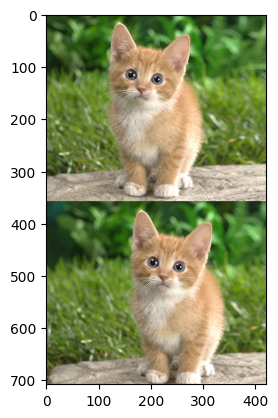

In [35]:
img_path = 'inputs/cat2.jpeg'
#img_path = 'inputs/ADE_val_00000297.jpg'
crop_size = 480
padding = [0.0] * 3
image = Image.open(img_path)
image = np.array(image)
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
    ]
)
image = transform(image).unsqueeze(0)
img = image[0].permute(1,2,0)
img = img * 0.5 + 0.5
plt.imshow(img)

In [36]:
#args.label_src = 'person,other'
args.label_src = 'plant,grass,cat,stone,other'

In [37]:
labels = []
print('** Input label value: {} **'.format(args.label_src))
lines = args.label_src.split(',')
for line in lines:
    label = line
    labels.append(label)

with torch.no_grad():
    outputs = evaluator.parallel_forward(image, labels) #evaluator.forward(image, labels) #parallel_forward
    #outputs = model(image,labels)
    predicts = [
        torch.max(output, 1)[1].cpu().numpy() 
        for output in outputs
    ]
    
predict = predicts[0]

** Input label value: plant,grass,cat,stone,other **
** MultiEvalModule parallel_forward phase: ['plant', 'grass', 'cat', 'stone', 'other'] **
** MultiEvalModule forward phase: ['plant', 'grass', 'cat', 'stone', 'other'] **


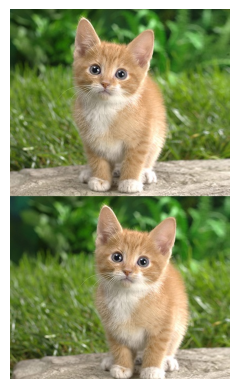

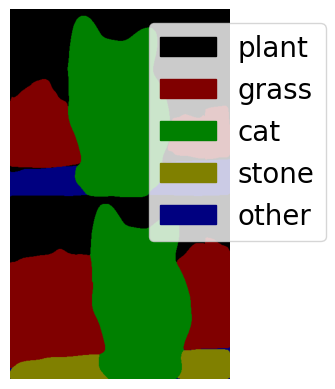

In [38]:
# show results
new_palette = get_new_pallete(len(labels))
mask, patches = get_new_mask_pallete(predict, new_palette, out_label_flag=True, labels=labels)
img = image[0].permute(1,2,0)
img = img * 0.5 + 0.5
img = Image.fromarray(np.uint8(255*img)).convert("RGBA")
seg = mask.convert("RGBA")
out = Image.blend(img, seg, alpha)
plt.axis('off')
plt.imshow(img)
plt.figure()
plt.legend(handles=patches, loc='upper right', bbox_to_anchor=(1.5, 1), prop={'size': 20})
plt.axis('off')
plt.imshow(seg)

In [39]:
def draw_rectangle(draw, coordinates, color, width=1):
    for i in range(width):
        rect_start = (coordinates[0][0] - i, coordinates[0][1] - i)
        rect_end = (coordinates[1][0] + i, coordinates[1][1] + i)
        draw.rectangle((rect_start, rect_end), outline = color)

def comparePixel(pxA,pxB):
    for i in range(len(pxA)):
       # print(type(pxA))
       # print(type(pxB))
        if pxA[i] != pxB[i]:
            return False
    return True

In [40]:
def palette_to_rgba(new_palette):
    colors = [] 
    for i in range(2,len(new_palette),3): #new_pallete is a contiguous tuple of rgb values
        colors.append([new_palette[i-2],new_palette[i-1],new_palette[i]])
    rgba_cols = []
    for color in colors:
        color.append(255)
        rgba_cols.append(np.array(color))
    return rgba_cols #colors of each label for the segmap

def process_segmap(rgba_cols, seg):
    bboxes = []
    segmaps = []

    for rgba_col in rgba_cols:
        test_seg = np.array(seg).copy()
        xmin = ymin = 99999
        xmax = ymax = 0
        #separate the segments, put in a larger loop for each label
        for col in range(0,len(test_seg)):
            #print(row)
            for row in range(0,len(test_seg[col])):
                if not comparePixel(test_seg[col][row],rgba_col):
                    test_seg[col][row] = [0,0,0,0] #make transparent
                else: #get top left and bottom right to draw rectangle
                    if row>xmax:
                        xmax = row
                    if col>ymax:
                        ymax = col
                    if row<xmin:
                        xmin = row
                    if col<ymin:
                        ymin = col
        bboxes.append([xmin,ymin,xmax,ymax])
        segmaps.append(test_seg)
    return bboxes, segmaps
    #Image.fromarray(test_seg)

In [41]:
rgba_cols = palette_to_rgba(new_palette)
bboxes, segmaps = process_segmap(rgba_cols,seg)

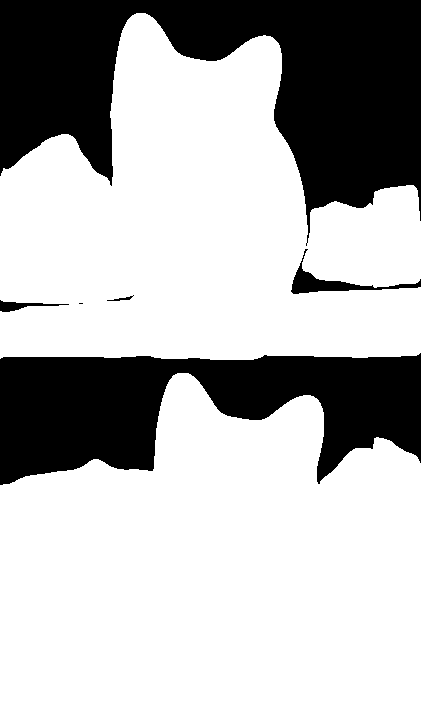

In [42]:
Image.fromarray(segmaps[0])

In [43]:
bboxes

[[0, 0, 420, 484],
 [0, 134, 420, 686],
 [110, 13, 347, 707],
 [0, 651, 420, 707],
 [0, 287, 420, 707]]

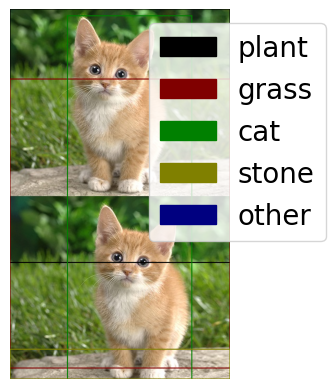

In [44]:
from PIL import Image, ImageDraw
img_copy = img.copy()
for i in range(0,len(bboxes)-1): #the other BBOX got bug, so minus 1
    topLeft = (bboxes[i][0],bboxes[i][1])
    bottomRight = (bboxes[i][2],bboxes[i][3])
    img1 = ImageDraw.Draw(img_copy)
    #rect_color = getHexColor(rgba_cols[i])
    draw_rectangle(img1, (topLeft,bottomRight),color = tuple(rgba_cols[i]), width=2)
plt.legend(handles=patches, loc='upper right', bbox_to_anchor=(1.5, 1), prop={'size': 20})
plt.axis('off')
plt.imshow(img_copy)

In [45]:
#find the bounding box for empty gap within the existing bounding box
#perform horizontal scan for contiguous blank box


def contiguous_transparency_scan(box,segmap,instance_threshold=5):
    #iterative vertical scan (left to right scan every column)
    min_x = max_x = -1
    for x in range(box[0],box[2]):
        isContiguous = True
        count_colored = 0
        for y in range(box[1],box[3]):
            #print(x,y)
            if not comparePixel(segmap[y][x],[0,0,0,0]):
                count_colored+=1
                if count_colored>=instance_threshold:
                    isContiguous = False
                    break
        if isContiguous:
            if min_x==-1:
                min_x = x
                max_x = min_x
            else:
                max_x +=1
    #print(min_x,max_x) 
    #iterative horizontal scan (top to bottom scan every row)
    min_y = max_y = -1
    for y in range(box[1],box[3]):
        isContiguous = True
        count_colored = 0
        for x in range(box[0],box[2]):
            if not comparePixel(segmap[y][x],[0,0,0,0]):
                count_colored+=1
                if count_colored>=instance_threshold:
                    isContiguous = False
                    break
                isContiguous = False
                break
        if isContiguous:
            if min_y==-1:
                min_y = y
                max_y = min_y
            else:
                max_y +=1
    #if max_x - min_x>0 or arbitary threshold means there is a gap in the segmentation
    # if the above is true, that means the bounding box can be instanced into a left and right instance
    # if max_y - min_y >0 or arbitary threshold, means thee boundingbox can be instanced into a top and bottom instance
    return [min_x,max_x],[min_y,max_y]


In [46]:
#optimize the new boxes to fit nicely around the segment instance
def optimizeBoxes(bbox,segmap):
    new_boxes = []

    for box in bbox:
        xmin = ymin = 99999
        xmax = ymax = 0
        for col in range(box[0],box[2]):
            for row in range(box[1],box[3]):
                if not comparePixel(segmap[row][col], [0,0,0,0]):
                    if col>xmax:
                        xmax = col
                    if row>ymax:
                        ymax = row
                    if col<xmin:
                        xmin = col
                    if row<ymin:
                        ymin = row
        if [xmin,ymin,xmax,ymax] != [99999,99999,0,0]:
            new_boxes.append([xmin,ymin,xmax,ymax])
        else:
            new_boxes.append(box)

    return new_boxes

#split boxes and optimize
def splitBox(box,x_split, y_split, segmap):
    bbox = []
    if x_split[0]==-1 and y_split[0]==-1:
        return
    elif x_split[0]==-1:
        #splt top and bottom
        top_box = [box[0],y_split[0],box[2],box[3]]
        bot_box = [box[0],box[1],box[2],y_split[1]]
        #bbox = [top_box,bot_box]
        bbox = optimizeBoxes([top_box,bot_box],segmap)
    else:
        #split left and right
        left_box = [box[0],box[1],x_split[0],box[3]]
        right_box = [x_split[1],box[1],box[2],box[3]]
        #bbox = [left_box,right_box]
        bbox = optimizeBoxes([left_box,right_box],segmap)
    return bbox

In [47]:
def boxSize(box):
    x = box[2]-box[0]
    y = box[3]-box[1]
    return x*y

#return max similarity value for each variable
def boxSimilarity(box1,box2):
    x1 = abs(box2[0]-box1[0])
    y1 = abs(box2[1]-box1[1])
    x2 = abs(box2[2]-box1[2])
    y2 = abs(box2[3]-box1[3])
    return max([x1,y1,x2,y2])

In [48]:
#main function to instance the segmentation map based on horizontal and verticle gaps, as well as optimize the size
#boxes that are too similar or too small are also filtered out along the way
def bbox_instancing(bboxes,segmaps,min_size = 5):
    final_instances = []
    for idx in range(len(bboxes)): #number of classes
        box = bboxes[idx]
        segmap = segmaps[idx]

        box_instances = []
        instanced_boxes = [box]
        i = 0
        #iteratively instance boxes repeatedly until boxes cannot be instanced further
        while(i<len(instanced_boxes)):
            x_contiguous,y_contiguous = contiguous_transparency_scan(instanced_boxes[i],segmap,instance_threshold=0)
            new_bboxes = splitBox(instanced_boxes[i],x_contiguous,y_contiguous,segmap)
            #print(new_bboxes)
            if new_bboxes != None:
                new_count = 0
                for new_box in new_bboxes:
                    if boxSize(new_box)>min_size:
                        instanced_boxes.append(new_box) #append the 2 instances
                        new_count+=1
                if new_count>0: #if at least one new box is added
                    instanced_boxes.pop(i) #remove the box that got split into 2 instances 
                    i-=1
            i+=1
        #filter out similar boxes that are adjacent
        i=0
        while(i<len(instanced_boxes)-1):

            sim = boxSimilarity(instanced_boxes[i],instanced_boxes[i+1])
            if (sim<5): #too similar
                print(instanced_boxes[i],instanced_boxes[i+1])
                # remove smaller box
                if boxSize(instanced_boxes[i])>boxSize(instanced_boxes[i+1]):
                    instanced_boxes.pop(i+1)
                else:
                    instanced_boxes.pop(i)
                i-=1
            i+=1
        final_instances.append(instanced_boxes)
    return final_instances

In [49]:
new_bbox = bbox_instancing(bboxes,segmaps,min_size=50)
new_bbox

[[[292, 249, 418, 289],
  [0, 0, 418, 245],
  [0, 355, 417, 481],
  [0, 300, 68, 310],
  [291, 249, 417, 293],
  [0, 300, 68, 310],
  [114, 296, 131, 299]],
 [[0, 459, 180, 684],
  [0, 134, 135, 303],
  [319, 437, 418, 651],
  [302, 185, 418, 287]],
 [[153, 373, 346, 706], [110, 13, 307, 359]],
 [[0, 661, 186, 706], [321, 651, 419, 706]],
 [[0, 300, 146, 358],
  [365, 649, 417, 652],
  [265, 288, 417, 357],
  [354, 649, 416, 651],
  [265, 288, 416, 357]]]

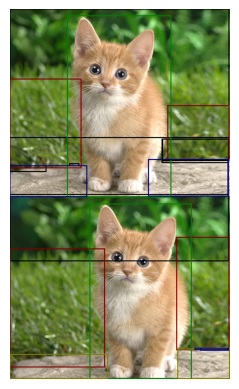

In [50]:
#sample bbox instancing result
from PIL import Image, ImageDraw
img_copy_test = img.copy()
for i in range(len(new_bbox)):
    for j in range(len(new_bbox[i])):
        topLeft = (new_bbox[i][j][0],new_bbox[i][j][1])
        bottomRight = (new_bbox[i][j][2],new_bbox[i][j][3])
        img1 = ImageDraw.Draw(img_copy_test)
        #rect_color = getHexColor(rgba_cols[i])
        draw_rectangle(img1, (topLeft,bottomRight),color = tuple(rgba_cols[i]), width=2)
        #draw_rectangle(img1, (topLeft,bottomRight),color = "red", width=2)
#plt.legend(handles=patches, loc='upper right', bbox_to_anchor=(1.5, 1), prop={'size': 20})
plt.axis('off')
plt.imshow(img_copy_test)